In [ ]:
# Acknowledgment:
# This implementation draws inspiration and guidance from:
# 1. Nicholas Renotte's YouTube tutorial: https://www.youtube.com/watch?v=tepxdcepTbY
# 2. Coding the Smart Way's YouTube tutorial: https://www.youtube.com/watch?v=c0k-YLQGKjY

In [1]:
import kagglehub
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import SimpleRNN
import random

# 1. Data Preparing

In [2]:
# Download latest version
path = kagglehub.dataset_download("meetnagadia/coco-cola-stock-data-19622021")

print("Path to dataset files:", path)

Path to dataset files: /Users/oliviachan/.cache/kagglehub/datasets/meetnagadia/coco-cola-stock-data-19622021/versions/1


In [3]:
# read the dataset
df = pd.read_csv(path + '/COCO COLA.csv')

## 1.1 Print out details

In [4]:
# Print out data info
print(df.head())
print(df.shape)
print(df.dtypes)

         Date      Open      High       Low     Close  Adj Close   Volume
0  1962-01-02  0.263021  0.270182  0.263021  0.263021   0.051133   806400
1  1962-01-03  0.259115  0.259115  0.253255  0.257161   0.049994  1574400
2  1962-01-04  0.257813  0.261068  0.257813  0.259115   0.050374   844800
3  1962-01-05  0.259115  0.262370  0.252604  0.253255   0.049234  1420800
4  1962-01-08  0.251302  0.251302  0.245768  0.250651   0.048728  2035200
(15096, 7)
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [5]:
# Check for missing data
missing_data = df.isnull().sum()
print("Missing data in each column:")
print(missing_data)

# Additional Summary
total_missing = missing_data.sum()
print(f"\nTotal missing values in the dataset: {total_missing}")

Missing data in each column:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Total missing values in the dataset: 0


In [6]:
# Change Date as datetime and set it as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


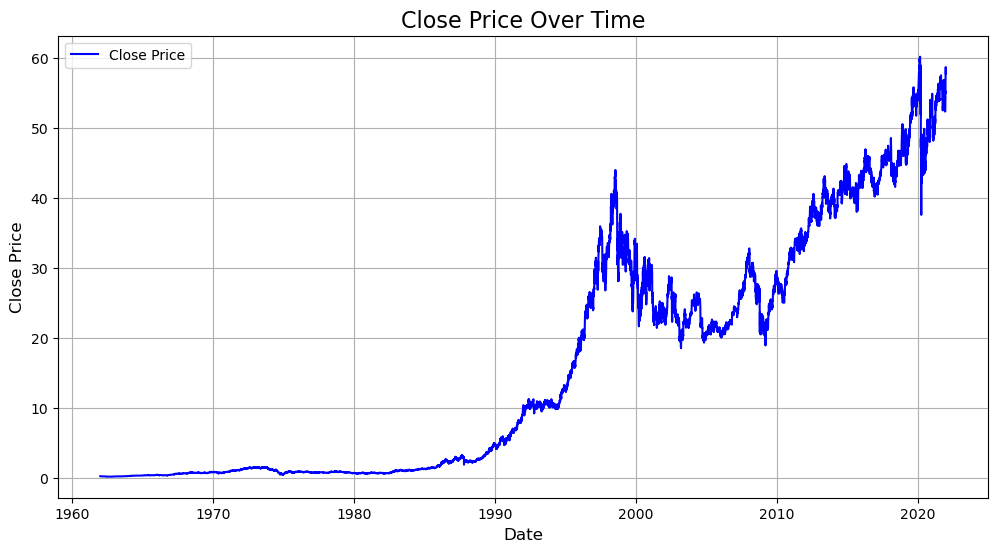

In [7]:
# Draw the trend of 'Close' (response variable)
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.title('Close Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


## 1.2 Select the time (2008-2018)

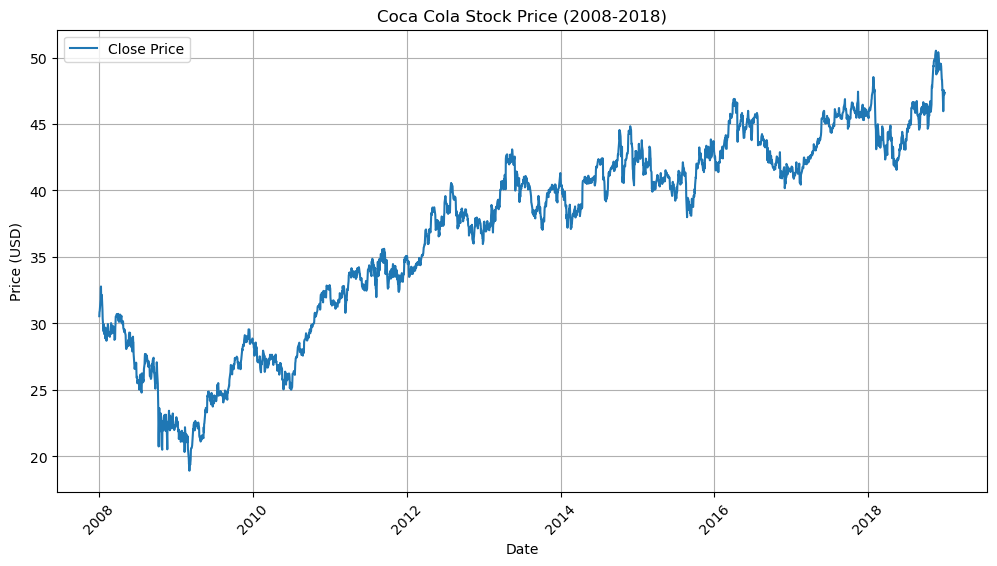

In [8]:
# Filter data from 2008 - 2018 (Since 2019 is the start of Covid, the price was greatly affected afterwards.)
df = df[(df.index >= '2008-01-01') & (df.index <= '2018-12-31')]

# Plot 'Close' during the period
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Price')
plt.title('Coca Cola Stock Price (2008-2018)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# 2. Data Preprocessing

## 2.1 Feature Selection

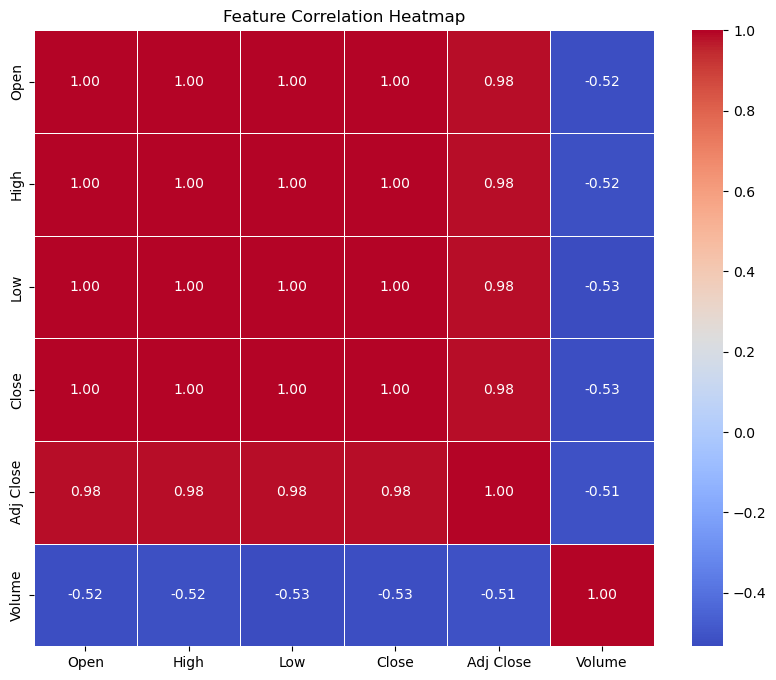

In [9]:
# Calculate the correlation
correlation_matrix = df.corr()

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

In [10]:
# Only keep 'Close' and 'Volume'
df = df.drop(['Adj Close', 'Open', 'High', 'Low'], axis=1)


## 2.2 Set window size

In [11]:
# Extract date range for each window and generate data using a window size of 20
def df_to_windowed_df(dataframe, window_size=20):
    dates = []
    X, Y = [], []
    
    for i in range(window_size, len(dataframe)):
        df_subset = dataframe.iloc[i-window_size:i]
        y = df_subset['Close'].iloc[-1]  
        x = df_subset.to_numpy()
        dates.append(df_subset.index[-1])
        X.append(x)
        Y.append(y)

    X = np.array(X)
    Y = np.array(Y)

    return dates, X, Y


dates, X, y = df_to_windowed_df(df, window_size=20)

# Check the data
print(dates[:5])  # Show the first 5 data points
print(dates[-5:]) # Show the last 5 data points
print(X.shape)  # Show X shape
print(y.shape)  # Show y shape

[Timestamp('2008-01-30 00:00:00'), Timestamp('2008-01-31 00:00:00'), Timestamp('2008-02-01 00:00:00'), Timestamp('2008-02-04 00:00:00'), Timestamp('2008-02-05 00:00:00')]
[Timestamp('2018-12-21 00:00:00'), Timestamp('2018-12-24 00:00:00'), Timestamp('2018-12-26 00:00:00'), Timestamp('2018-12-27 00:00:00'), Timestamp('2018-12-28 00:00:00')]
(2749, 20, 2)
(2749,)


## 2.3 Data Splitting

Training data shape: (1924, 20, 2)
Validation data shape: (412, 20, 2)
Test data shape: (413, 20, 2)


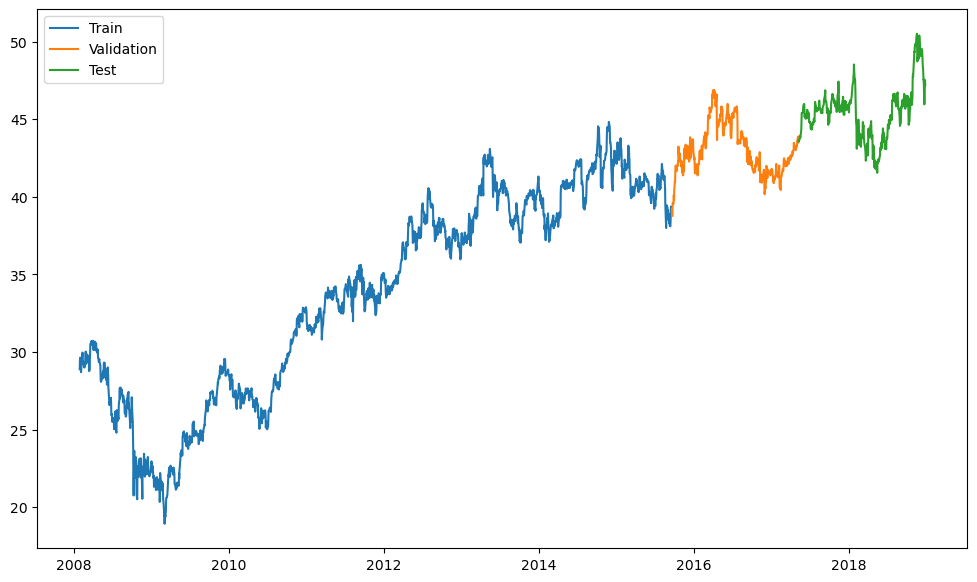

In [12]:
# Split train, val, test as 70:15:15
q_70 = int(len(dates) * .7)
q_85 = int(len(dates) * .85)

dates_train, X_train, y_train = dates[:q_70], X[:q_70], y[:q_70]  # Use 70% for training
dates_val, X_val, y_val = dates[q_70:q_85], X[q_70:q_85], y[q_70:q_85]  # 15% for validation
dates_test, X_test, y_test = dates[q_85:], X[q_85:], y[q_85:]  # 15% for testing

# Print data shapes to check splits
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)

# Check the data
plt.figure(figsize=(12, 7))
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.legend(['Train', 'Validation', 'Test'])

## 2.4 Data Normalisation

In [13]:
# Scaling X and y
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train.reshape(X_train.shape[0], -1))
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

X_val_scaled = scaler_X.transform(X_val.reshape(X_val.shape[0], -1))
X_test_scaled = scaler_X.transform(X_test.reshape(X_test.shape[0], -1))

y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Reshape X to 3D shape (samples, timesteps, features) for LSTM
X_train_scaled = X_train_scaled.reshape(X_train.shape[0], X_train.shape[1], -1)
X_val_scaled = X_val_scaled.reshape(X_val.shape[0], X_val.shape[1], -1)
X_test_scaled = X_test_scaled.reshape(X_test.shape[0], X_test.shape[1], -1)

# Check the shape
print(X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape)
print(y_train_scaled.shape, y_val_scaled.shape, y_test_scaled.shape)

(1924, 20, 2) (412, 20, 2) (413, 20, 2)
(1924, 1) (412, 1) (413, 1)


# 3. Modeling

In [14]:
# Set the random seed
def set_random_seed(seed_value=168):
    np.random.seed(seed_value)
    random.seed(seed_value)
    tf.random.set_seed(seed_value)

## 3.1 Build RNN Model (Baseline Model)

In [15]:
def create_rnn_model(optimizer, rnn_units=10):
    set_random_seed()
    model = Sequential()
    model.add(SimpleRNN(rnn_units, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    # RNN layer
    model.add(Dense(1))  # output layer
    model.compile(optimizer=optimizer, loss='mean_squared_error')  # Using MSE as loss function
    return model


In [16]:
# Set rnn_unit
baseline_rnn_model = create_rnn_model(optimizer=Adam(learning_rate=0.1))
history_baseline_rnn = baseline_rnn_model.fit(X_train_scaled, y_train_scaled, epochs=20, batch_size=64, validation_data=(X_val_scaled, y_val_scaled))

Epoch 1/20


/Users/oliviachan/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1568 - val_loss: 0.0150
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - val_loss: 0.0010
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3344e-04 - val_loss: 6.5693e-04
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6011e-04 - val_loss: 5.5429e-04
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8047e-04 - val_loss: 3.0393e-04
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2563e-04 - val_loss: 4.4857e-04
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2444e-04 - val_loss: 2.7772e-04
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6907e-05 - val_loss: 3.0566e-04
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1078e-05 - val_loss: 1.9375e-04
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2852e-05 - val_loss: 2.0893e-04
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0484e-05 - val_loss: 5.6354e-05
Epoch 12/20


In [17]:
# Evaluate Baseline Model
train_loss = baseline_rnn_model.evaluate(X_train_scaled, y_train_scaled)
val_loss = baseline_rnn_model.evaluate(X_val_scaled, y_val_scaled)

print(f"Train Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 6.8192e-05
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - loss: 2.0864e-04
Train Loss: 8.784767123870552e-05
Validation Loss: 0.00019494957814458758


In [18]:
# Function for calculate rmse, r2 and unscale y
def calculate_rmse_r2(y_true, y_pred_scaled, scaler_y):
    # Inverse transform the predicted values to get unscaled predictions
    y_pred_unscaled = scaler_y.inverse_transform(y_pred_scaled)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_unscaled))

    # Calculate R²
    r2 = r2_score(y_true, y_pred_unscaled)

    return rmse, r2, y_pred_unscaled

In [19]:
# Train set predictions
y_train_pred_scaled_rnn = baseline_rnn_model.predict(X_train_scaled)
train_rmse_rnn, train_r2_rnn, y_train_pred_unscaled_rnn = calculate_rmse_r2(y_train, y_train_pred_scaled_rnn, scaler_y)

# Validation set predictions
y_val_pred_scaled_rnn = baseline_rnn_model.predict(X_val_scaled)
val_rmse_rnn, val_r2_rnn, y_val_pred_unscaled_rnn = calculate_rmse_r2(y_val, y_val_pred_scaled_rnn, scaler_y)

# Print the results
print(f"Baseline Train RMSE: {train_rmse_rnn}")
print(f"Baseline Train R²: {train_r2_rnn}")
print(f"Baseline Validation RMSE: {val_rmse_rnn}")
print(f"Baseline Validation R²: {val_r2_rnn}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
Baseline Train RMSE: 0.24279959792365155
Baseline Train R²: 0.998628168267082
Baseline Validation RMSE: 0.36169599696423016
Baseline Validation R²: 0.9490564197234229


## 3.2 RNN Hyperparameter Tuning

In [21]:
# Function for hyperparameter tuning without optimizing rnn_units
def tune_and_save_best_model(name, param_grid, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled):
    # Initialize the best score as high as possible
    best_score = float('inf')
    best_params = None
    best_model = None

    # List to store results for each combination
    tuning_results = []

    # Define early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitor validation loss
        patience=5,          # Stop after 5 epochs without improvement
        restore_best_weights=True  # Restore the weights from the best epoch
    )

    # Manually loop through the hyperparameter combinations
    for batch_size in param_grid['batch_size']:
        for epochs in param_grid['epochs']:
            for learning_rate in param_grid['learning_rate']:  # Add learning rate to the grid
                print(f"Training with: batch_size={batch_size}, epochs={epochs}, learning_rate={learning_rate}")
                # Create and compile the model with the specified learning rate
                optimizer = Adam(learning_rate=learning_rate)  # Set learning rate for Adam optimizer
                if name == 'rnn':
                    model = create_rnn_model(optimizer=optimizer) 
                else:
                    model = create_lstm_model(optimizer=optimizer)
                    
                # Train the model
                history = model.fit(
                    X_train_scaled, y_train_scaled, 
                    validation_data=(X_val_scaled, y_val_scaled), 
                    epochs=epochs, batch_size=batch_size, 
                    verbose=0, callbacks=[early_stopping]  # Add early stopping here
                )
                    
                # Get the validation loss (or any other metric you want)
                val_loss = history.history['val_loss'][-1]
                print(f"Validation Loss: {val_loss}")
                    
                # Save the result for this combination
                tuning_results.append({
                    'batch_size': batch_size,
                    'epochs': epochs,
                    'learning_rate': learning_rate,
                    'validation_loss': val_loss
                })
                    
                # Track the best model
                if val_loss < best_score:
                    best_score = val_loss
                    best_params = {
                        'batch_size': batch_size,
                        'epochs': epochs,
                        'learning_rate': learning_rate
                    }
                    best_model = model

    # Print the best parameters and validation score
    print("Best Parameters: ", best_params)
    print("Best Validation Loss: ", best_score)

    # Optionally, save the best model
    best_model.save('best_model.h5')

    # Save the results to a CSV file for comparison
    tuning_results_df = pd.DataFrame(tuning_results)
    tuning_results_df.to_csv('hyperparameter_tuning_results.csv', index=False)

    return best_model, best_params, best_score, history


In [22]:
# Tuning RNN
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [20, 50, 100],
    'learning_rate': [0.1, 0.01, 0.001]
}
# Assuming X_train_scaled, y_train_scaled, X_val_scaled, and y_val_scaled are defined
best_rnn_model, best_rnn_params, best_rnn_score, best_rnn_history = tune_and_save_best_model('rnn', param_grid, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled)


Training with: batch_size=16, epochs=20, learning_rate=0.1


/Users/oliviachan/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss: 7.312215166166425e-05
Training with: batch_size=16, epochs=20, learning_rate=0.01
Validation Loss: 0.00015687555423937738
Training with: batch_size=16, epochs=20, learning_rate=0.001
Validation Loss: 0.001823277911171317
Training with: batch_size=16, epochs=50, learning_rate=0.1
Validation Loss: 0.001031385618261993
Training with: batch_size=16, epochs=50, learning_rate=0.01
Validation Loss: 0.00015687555423937738
Training with: batch_size=16, epochs=50, learning_rate=0.001
Validation Loss: 0.001823277911171317
Training with: batch_size=16, epochs=100, learning_rate=0.1
Validation Loss: 0.001031385618261993
Training with: batch_size=16, epochs=100, learning_rate=0.01
Validation Loss: 0.00015687555423937738
Training with: batch_size=16, epochs=100, learning_rate=0.001
Validation Loss: 0.001823277911171317
Training with: batch_size=32, epochs=20, learning_rate=0.1
Validation Loss: 0.0014632315142080188
Training with: batch_size=32, epochs=20, learning_rate=0.01
Validatio

Validation Loss: 0.008565619587898254
Best Parameters:  {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.1}
Best Validation Loss:  7.312215166166425e-05


In [23]:
# Obtain best RNN model train and val RMSE and r2

# Train set predictions
best_rnn_y_train_pred_scaled = best_rnn_model.predict(X_train_scaled)
best_rnn_train_rmse, best_rnn_train_r2, best_rnn_y_train_pred_unscaled = calculate_rmse_r2(y_train, best_rnn_y_train_pred_scaled, scaler_y)

# Validation set predictions
best_rnn_y_val_pred_scaled = best_rnn_model.predict(X_val_scaled)
best_rnn_val_rmse, best_rnn_val_r2, best_rnn_y_val_pred_unscaled = calculate_rmse_r2(y_val, best_rnn_y_val_pred_scaled, scaler_y)

# Print the results
print(f"Best RNN Train RMSE: {best_rnn_train_rmse}")
print(f"Best RNN Train R²: {best_rnn_train_r2}")
print(f"Best RNN Validation RMSE: {best_rnn_val_rmse}")
print(f"Best RNN Validation R²: {best_rnn_val_r2}")


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
Best RNN Train RMSE: 0.12536360926780402
Best RNN Train R²: 0.9996342806893213
Best RNN Validation RMSE: 0.14530203760132349
Best RNN Validation R²: 0.9917786058787421


In [36]:
def plot_loss(history, name):
    """
    Plot training and validation loss over epochs.

    Parameters:
    - history: The history object returned by model.fit().
    - title: Title for the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title(f"{name} Training and Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


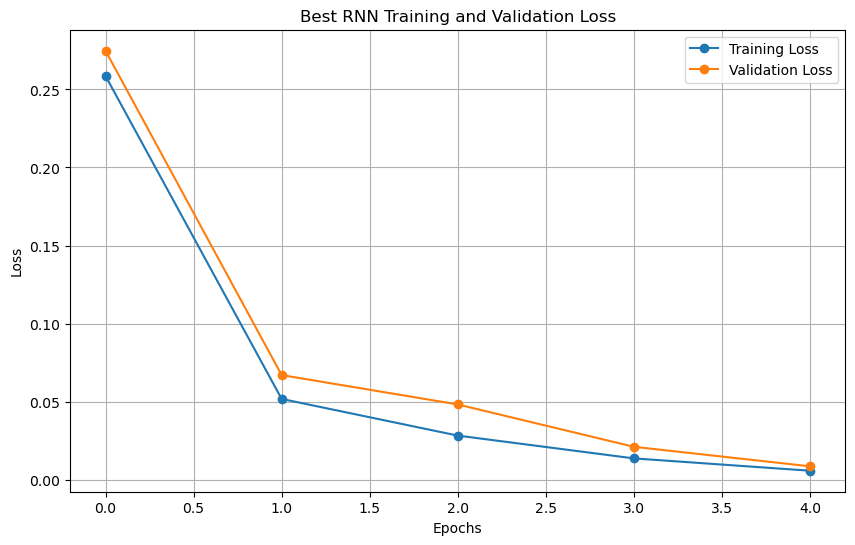

In [37]:
plot_loss(best_rnn_history, "Best RNN")

## 3.3 Build LSTM Model

In [26]:
# Build LSTM model
def create_lstm_model(optimizer, lstm_units=10):
    set_random_seed()
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    model.add(Dense(1)) 
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

## 3.4 LSTM Hyperparameter Tuning

In [27]:
# Tuning LSTM
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [20, 50, 100],
    'learning_rate': [0.1, 0.01, 0.001]
}
# Assuming X_train_scaled, y_train_scaled, X_val_scaled, and y_val_scaled are defined
best_lstm_model, best_lstm_params, best_lstm_score, best_lstm_history = tune_and_save_best_model('lstm', param_grid, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled)


Training with: batch_size=16, epochs=20, learning_rate=0.1


/Users/oliviachan/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss: 9.264377149520442e-05
Training with: batch_size=16, epochs=20, learning_rate=0.01
Validation Loss: 0.00020777483587153256
Training with: batch_size=16, epochs=20, learning_rate=0.001
Validation Loss: 0.0008086705929599702
Training with: batch_size=16, epochs=50, learning_rate=0.1
Validation Loss: 0.00011879221710842103
Training with: batch_size=16, epochs=50, learning_rate=0.01
Validation Loss: 0.00020777483587153256
Training with: batch_size=16, epochs=50, learning_rate=0.001
Validation Loss: 0.0008086705929599702
Training with: batch_size=16, epochs=100, learning_rate=0.1
Validation Loss: 0.00011879221710842103
Training with: batch_size=16, epochs=100, learning_rate=0.01
Validation Loss: 0.00020777483587153256
Training with: batch_size=16, epochs=100, learning_rate=0.001
Validation Loss: 0.0008086705929599702
Training with: batch_size=32, epochs=20, learning_rate=0.1
Validation Loss: 0.0007630576728843153
Training with: batch_size=32, epochs=20, learning_rate=0.01
Va

Validation Loss: 0.00173867994453758
Best Parameters:  {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.1}
Best Validation Loss:  9.264377149520442e-05


In [28]:
# Obtain best LSTM model train and val rmse and r2

# Train set predictions
best_lstm_y_train_pred_scaled = best_lstm_model.predict(X_train_scaled)
best_lstm_train_rmse, best_lstm_train_r2, best_lstm_y_train_pred_unscaled = calculate_rmse_r2(y_train, best_lstm_y_train_pred_scaled, scaler_y)

# Validation set predictions
best_lstm_y_val_pred_scaled = best_lstm_model.predict(X_val_scaled)
best_lstm_val_rmse, best_lstm_val_r2, best_lstm_y_val_pred_unscaled = calculate_rmse_r2(y_val, best_lstm_y_val_pred_scaled, scaler_y)

# Print the results
print(f"Best LSTM Train RMSE: {best_lstm_train_rmse}")
print(f"Best LSTM Train R²: {best_lstm_train_r2}")
print(f"Best LSTM Validation RMSE: {best_lstm_val_rmse}")
print(f"Best LSTM Validation R²: {best_lstm_val_r2}")


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
Best LSTM Train RMSE: 0.14671441816478606
Best LSTM Train R²: 0.9994991006022387
Best LSTM Validation RMSE: 0.21182880457992065
Best LSTM Validation R²: 0.9825268144104983


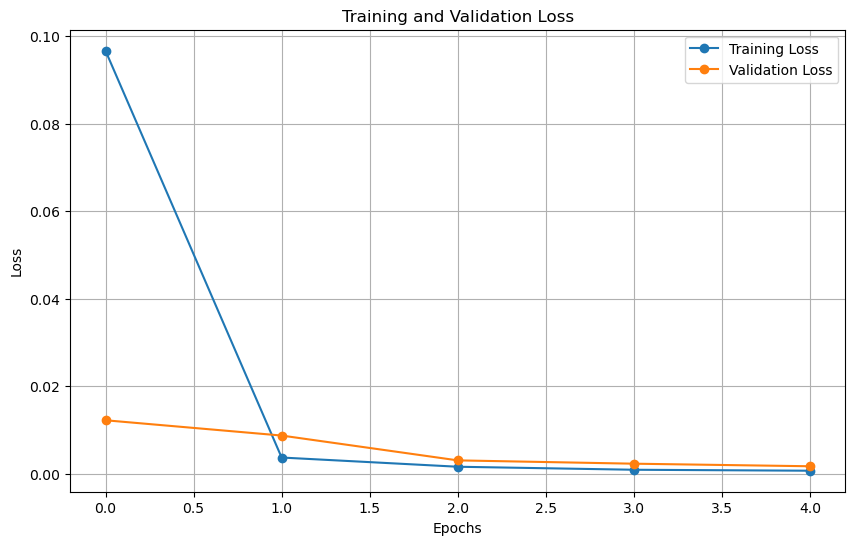

In [29]:
plot_loss(best_lstm_history)

# 4. Model Evaluation and Comparison

In [30]:
# Compare best RNN and RMSE train and val evaluation matrices

# Results dictionary
results_data = {
    "Model": ["Baseline RNN", "RNN", "LSTM"],
    "Train RMSE": [train_rmse_rnn, best_rnn_train_rmse, best_lstm_train_rmse],
    "Train R²": [train_r2_rnn, best_rnn_train_r2, best_lstm_train_r2],
    "Validation RMSE": [val_rmse_rnn, best_rnn_val_rmse, best_lstm_val_rmse],
    "Validation R²": [val_r2_rnn, best_rnn_val_r2, best_lstm_val_r2]
}

# Create a DataFrame
results_df = pd.DataFrame(results_data)

# Display the table
print(results_df)

          Model  Train RMSE  Train R²  Validation RMSE  Validation R²
0  Baseline RNN    0.242800  0.998628         0.361696       0.949056
1           RNN    0.125364  0.999634         0.145302       0.991779
2          LSTM    0.146714  0.999499         0.211829       0.982527


RNN works better on validation RMSE and R2 so RNN is chosen as the best model.

In [31]:
def evaluate_and_apply_best_model(test_data, test_labels, 
                                     baseline_rnn_model, best_rnn_model, best_lstm_model, 
                                     val_rmse_baseline_rnn, best_rnn_val_rmse, best_lstm_val_rmse):

    # Determine the model with the lowest validation RMSE
    rmse_dict = {
        "Baseline RNN": val_rmse_baseline_rnn,
        "Best RNN": best_rnn_val_rmse,
        "Best LSTM": best_lstm_val_rmse
    }
    selected_model_name = min(rmse_dict, key=rmse_dict.get)  # Select the model with the lowest RMSE

    # Map the selected model name to its corresponding model
    model_mapping = {
        "Baseline RNN": baseline_rnn_model,
        "Best RNN": best_rnn_model,
        "Best LSTM": best_lstm_model
    }
    selected_model = model_mapping[selected_model_name]

    # Apply the selected model to the test data
    best_y_test_pred_scaled = selected_model.predict(test_data)

    best_test_rmse, best_test_r2, best_y_test_pred_unscaled = calculate_rmse_r2(test_labels, best_y_test_pred_scaled, scaler_y)

    print(f"Selected Model: {selected_model_name}")
    print(f"Test RMSE: {best_test_rmse:.4f}")
    print(f"Test R2: {best_test_r2:.4f}")

    return selected_model_name, best_test_rmse, best_test_r2, best_y_test_pred_unscaled


In [32]:
selected_model_name, best_test_rmse, best_test_r2, best_y_test_pred_unscaled = evaluate_and_apply_best_model(X_test_scaled, y_test, baseline_rnn_model, best_rnn_model, best_lstm_model, val_rmse_rnn, best_rnn_val_rmse, best_lstm_val_rmse)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Selected Model: Best RNN
Test RMSE: 0.4434
Test R2: 0.9326


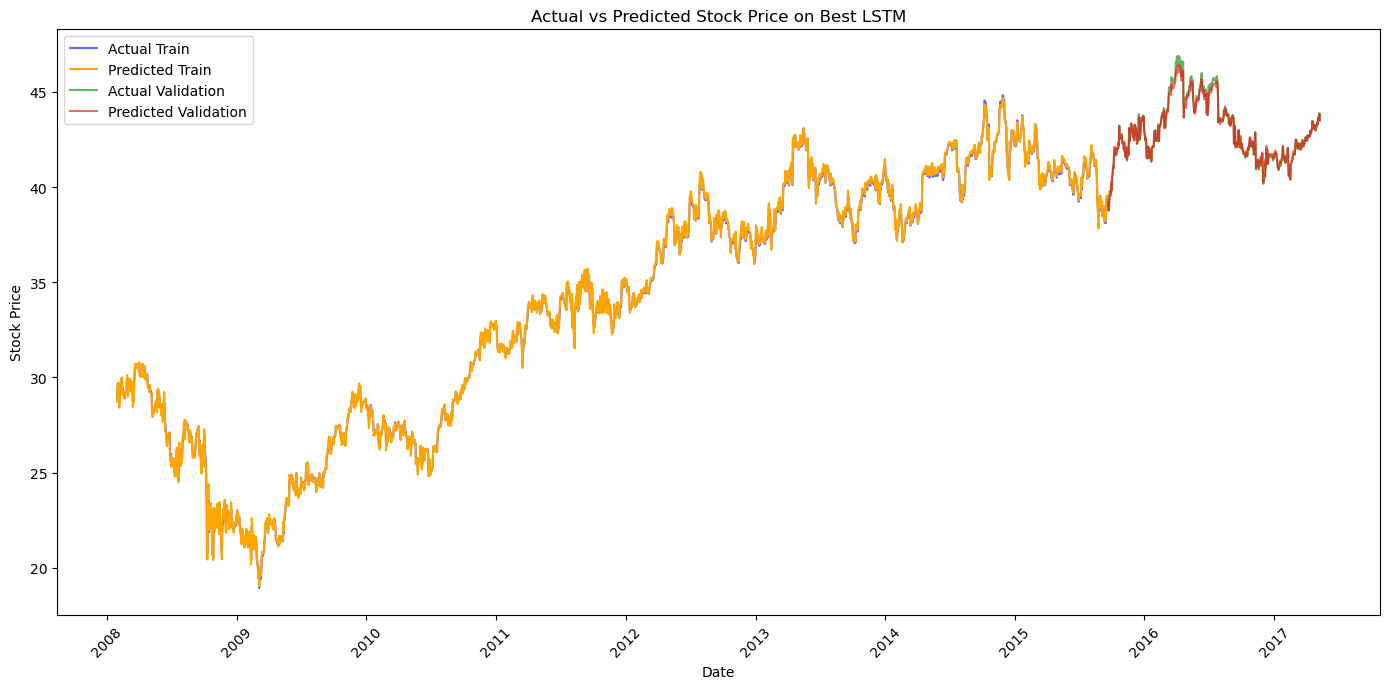

In [38]:
# Plot actual and predicted closing price on the best model (train and val)
plt.figure(figsize=(14, 7))

plt.plot(dates_train, y_train, label="Actual Train", color='blue', alpha=0.6)
plt.plot(dates_train, best_rnn_y_train_pred_unscaled, label="Predicted Train", color='orange', alpha=1)

plt.plot(dates_val, y_val, label="Actual Validation", color='green', alpha=0.6)
plt.plot(dates_val, best_rnn_y_val_pred_unscaled, label="Predicted Validation", color='red', alpha=0.6)

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Price on Best LSTM')
plt.legend(loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()


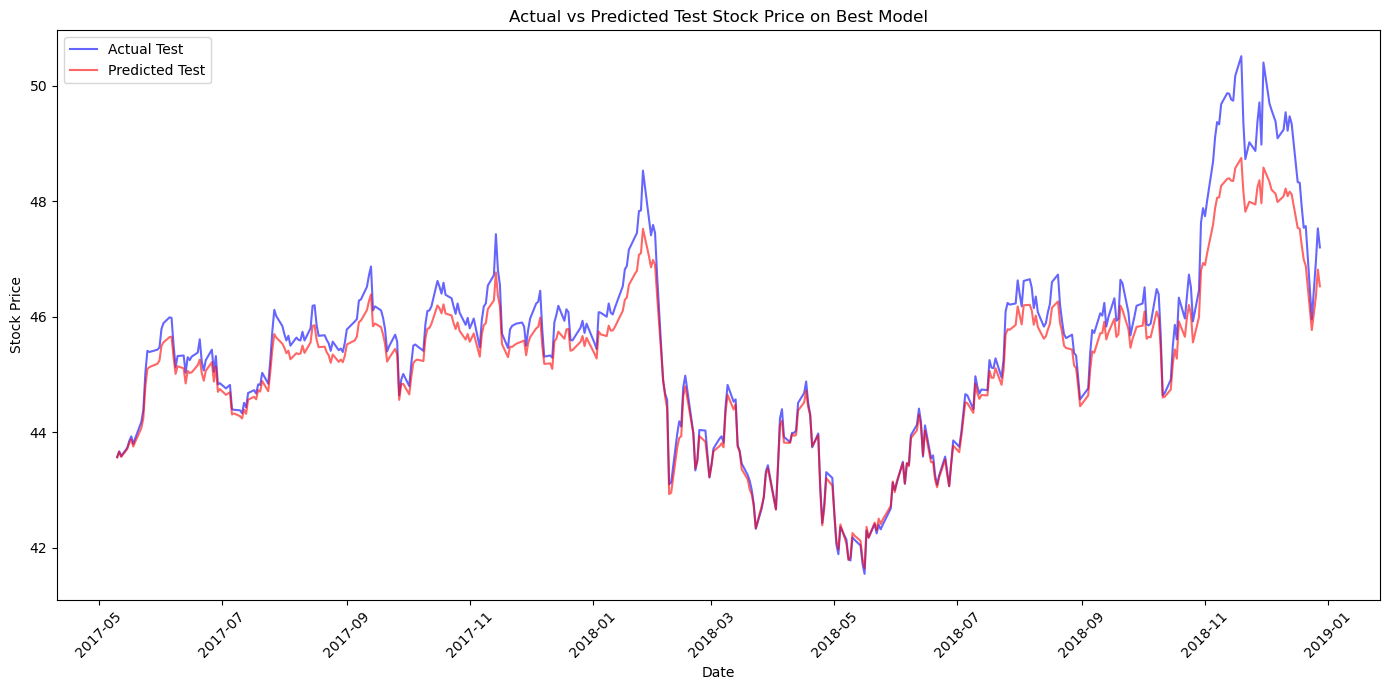

In [39]:
# Plot actual and predicted values on test set
plt.figure(figsize=(14, 7))

plt.plot(dates_test, y_test, label="Actual Test", color='blue', alpha=0.6)
plt.plot(dates_test, best_y_test_pred_unscaled, label="Predicted Test", color='red', alpha=0.6)

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Test Stock Price on Best Model')
plt.legend(loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()
